# Аугментация

In [72]:
import albumentations as alb
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [73]:
def gen_aug(index, sub_index):
    img = cv2.imread(f'input\img\image{index}.jpg')
    mask = cv2.imread(f'input\mask\mask{index}.jpg')
    
    # Создание объекта аугментации
    transform = alb.Compose([
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.RandomRotate90(p=0.5),
        alb.Affine(translate_percent={"x": 0.1, "y": 0.1}, rotate=(-45, 45), scale=(0.8, 1.2), p=1.0),
        alb.RandomScale(scale_limit=0.1, p=0.5), 
        alb.RandomCrop(height=300, width=300, p=0.5), 
        alb.RandomBrightnessContrast(p=0.4),
        alb.Blur(blur_limit=3, p=0.3),
    ])

    # Применение аугментации к изображению
    augmented_i = transform(image=img, mask=mask)
    # augmented_m = transform(image=mask)
    
    # Получение аугментированного изображения
    augmented_image = augmented_i['image']
    augmented_mask = augmented_i['mask']
    
    resized_image = cv2.resize(augmented_image, (300, 300))
    resized_mask = cv2.resize(augmented_mask, (300, 300))

    # Сохранение аугментированного изображения
    cv2.imwrite(f'augment/img/augmented_image_{index}_{sub_index}.jpg', resized_image)
    cv2.imwrite(f'augment/mask/augmented_mask_{index}_{sub_index}.jpg', resized_mask)

In [74]:
def plot_results(original_images, true_masks, predicted_masks, num=5):
    plt.figure(figsize=(20, 13))

    for i in range(num):
        idx = np.random.randint(len(original_images))
        plt.subplot(4, num, i + 1)
        plt.imshow(original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Image")

        plt.subplot(4, num, i + num + 1)
        plt.imshow(true_masks[idx], cmap="gray")
        plt.axis("off")
        plt.title("Original Mask")

        plt.subplot(4, num, i + 2 * num + 1)
        plt.imshow((predicted_masks[idx] > 0.5).astype(np.float32), cmap="gray")
        plt.axis("off")
        plt.title("Predicted Mask")
        
        plt.subplot(4, num, i + 3 * num + 1)
        plt.imshow(predicted_masks[idx] * original_images[idx], cmap="gray")
        plt.axis("off")
        plt.title("Predicted image")

    plt.show()

In [75]:
count_aug = 10
for i in range(2):
    for num in range(count_aug):
        gen_aug(i, num)

# Машиночитаемый вид

In [76]:
import numpy as np

In [77]:
def get_machine_img(index, sub_index):    
    img = cv2.imread(f'augment/img/augmented_image_{index}_{sub_index}.jpg')
    mask = cv2.imread(f'augment/mask/augmented_mask_{index}_{sub_index}.jpg', cv2.IMREAD_GRAYSCALE)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.resize(img, (300, 300))
    
    norm_img = img / 255.0
    # mask = cv2.resize(mask, (300, 300))
    norm_mask = (mask > 0).astype(np.float32) # бинаризация
    return (norm_img, norm_mask)
    

In [78]:
mass_img = []
mass_mask = [] 
for i in range(2):
    for num in range(count_aug):
        img, mask = get_machine_img(i, num)
        print(i, num, img.shape, mask.shape)
        mass_img.append(img), mass_mask.append(mask)
mass_img = np.array(mass_img)
mass_mask = np.array(mass_mask) 

0 0 (300, 300, 3) (300, 300)
0 1 (300, 300, 3) (300, 300)
0 2 (300, 300, 3) (300, 300)
0 3 (300, 300, 3) (300, 300)
0 4 (300, 300, 3) (300, 300)
0 5 (300, 300, 3) (300, 300)
0 6 (300, 300, 3) (300, 300)
0 7 (300, 300, 3) (300, 300)
0 8 (300, 300, 3) (300, 300)
0 9 (300, 300, 3) (300, 300)
1 0 (300, 300, 3) (300, 300)
1 1 (300, 300, 3) (300, 300)
1 2 (300, 300, 3) (300, 300)
1 3 (300, 300, 3) (300, 300)
1 4 (300, 300, 3) (300, 300)
1 5 (300, 300, 3) (300, 300)
1 6 (300, 300, 3) (300, 300)
1 7 (300, 300, 3) (300, 300)
1 8 (300, 300, 3) (300, 300)
1 9 (300, 300, 3) (300, 300)


# Создание модели

In [79]:
import tensorflow as tf
import matplotlib.pyplot as plt

## Полносвязная нейронная сеть

1. **Полносвязаня нейронная сеть** - Базовая многослойная нейронка.
Между каждым нейроном между двумя ближайшими слоями есть связь, обладающая каким-то весом.
У каждого слоя есть *"функция активации"* - функция, взаимодействующая со значением.
Тренировка происходит с помощью градиентного спуска.

In [80]:
from tensorflow import keras

In [81]:
mass_img[0].shape, mass_mask[0].shape

((300, 300, 3), (300, 300))

In [82]:
from sklearn.model_selection import train_test_split

In [83]:
x_t, x_v, y_t, y_v = train_test_split(mass_img, mass_mask, test_size=0.25, random_state=42)

In [84]:
x_t.shape

(15, 300, 300, 3)

In [85]:
# Создаем модель
model = keras.Sequential([
    # keras.layers.Input(shape=(x_t[0].shape)),
    keras.layers.Flatten(input_shape=(300, 300, 3)),
    keras.layers.Dense(1200, activation='relu'),
    keras.layers.Dense(600, activation='relu'),
    keras.layers.Dense(300 * 300, activation='sigmoid'),
    keras.layers.Reshape((300, 300, 1))
])

c:\PyInterpreters\BigData\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [86]:
# Компилируем модель
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision'])

In [87]:
# Обучаем модель
hst = model.fit(x=x_t, y=y_t, validation_data=(x_v, y_v), epochs=20, batch_size=15)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.4990 - loss: 0.6935 - precision: 0.7455 - val_accuracy: 0.6119 - val_loss: 0.6880 - val_precision: 0.7487
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6269 - loss: 0.6702 - precision: 0.8027 - val_accuracy: 0.7177 - val_loss: 0.7948 - val_precision: 0.7939
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7482 - loss: 0.6481 - precision: 0.8520 - val_accuracy: 0.7224 - val_loss: 0.5598 - val_precision: 0.7930
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7528 - loss: 0.4886 - precision: 0.8497 - val_accuracy: 0.7326 - val_loss: 0.5595 - val_precision: 0.7934
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7705 - loss: 0.4502 - precision: 0.8532 - val_accuracy: 0.7482 - val_loss: 0.4941 - val_precision: 0.8138
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7921 - loss: 0.4094 - precision: 0.8742 - val_accuracy: 0.7605 - val_loss: 0.5038 - val_precision: 0.8

In [88]:
model.predict(x_v)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


array([[[[1.6187946e-01],
         [2.0454058e-02],
         [1.5712857e-03],
         ...,
         [3.3333264e-03],
         [2.2234399e-02],
         [6.8209977e-03]],

        [[5.2537625e-03],
         [4.3563809e-02],
         [8.0106035e-03],
         ...,
         [2.6879639e-03],
         [1.7218612e-03],
         [7.2488422e-04]],

        [[1.4405664e-03],
         [2.2600247e-02],
         [6.9832439e-03],
         ...,
         [8.5698313e-04],
         [2.3384818e-03],
         [6.3921488e-04]],

        ...,

        [[9.9931574e-01],
         [9.9996775e-01],
         [9.9862176e-01],
         ...,
         [1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00]],

        [[9.9996102e-01],
         [9.9986804e-01],
         [9.9999905e-01],
         ...,
         [1.0000000e+00],
         [1.0000000e+00],
         [1.0000000e+00]],

        [[9.9999976e-01],
         [9.9999833e-01],
         [9.9894625e-01],
         ...,
         [1.0000000e+00],
        

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


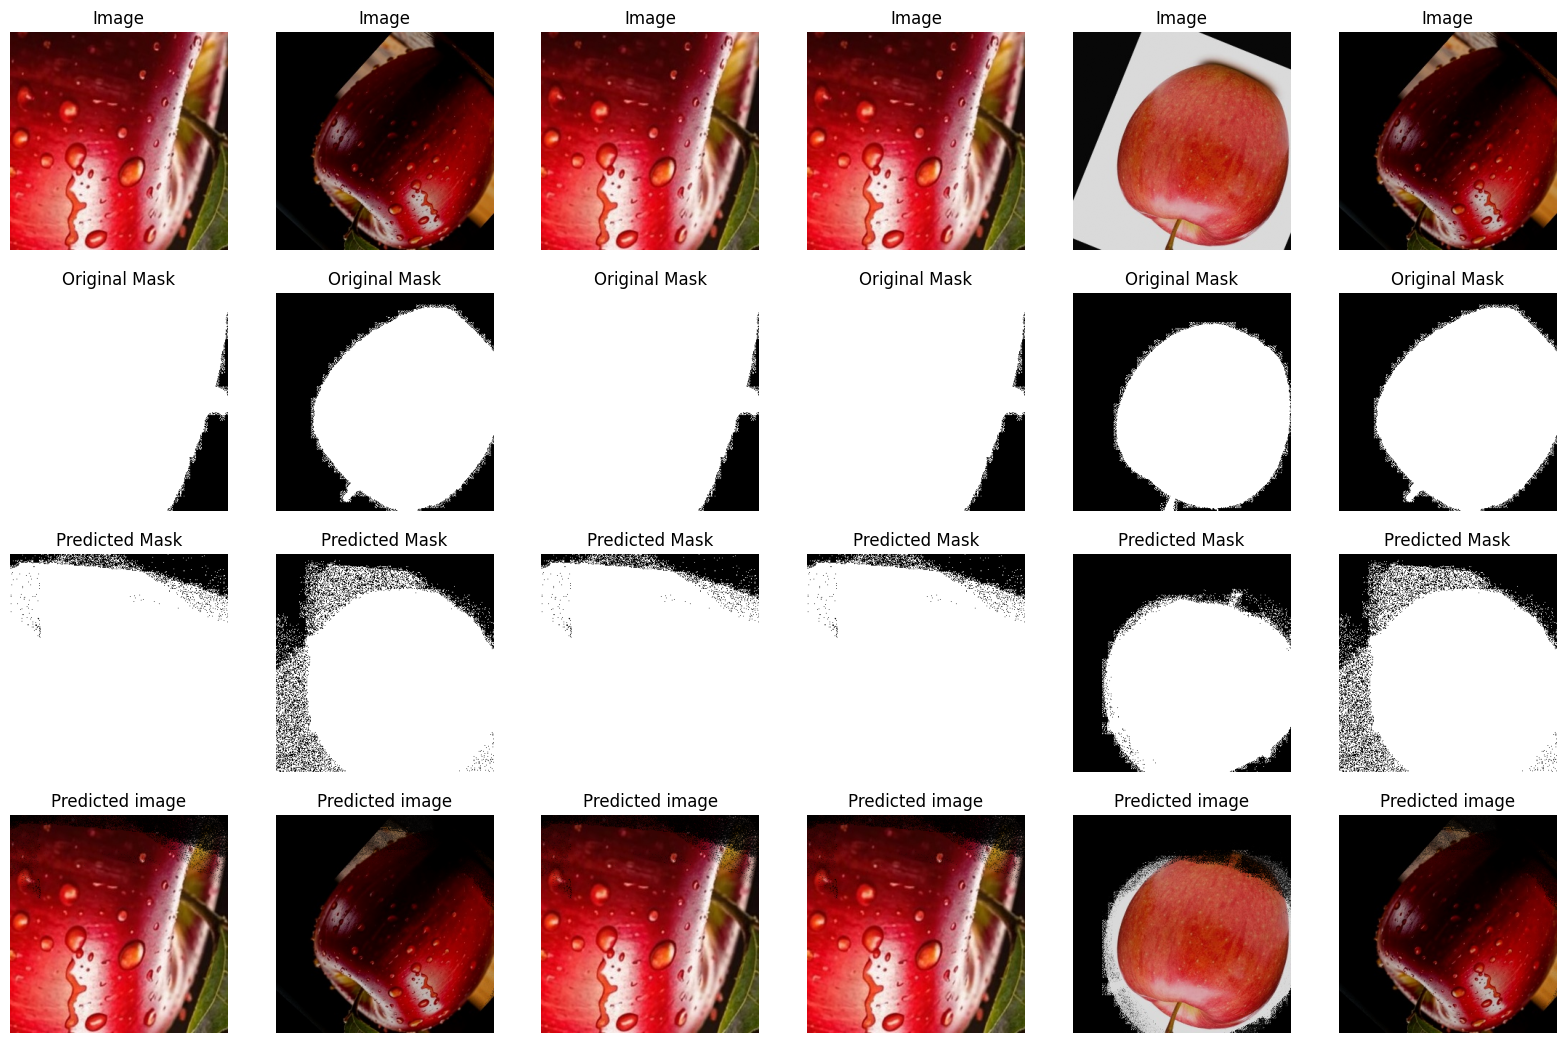

In [89]:
plot_results(x_v, y_v, model.predict(x_v), 2 * 3)

In [90]:
def plot_hist(history):
    # График потерь
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # График точности (accur)
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy during training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # График точности (prec)
    plt.subplot(1, 3, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Precision during training')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.show()


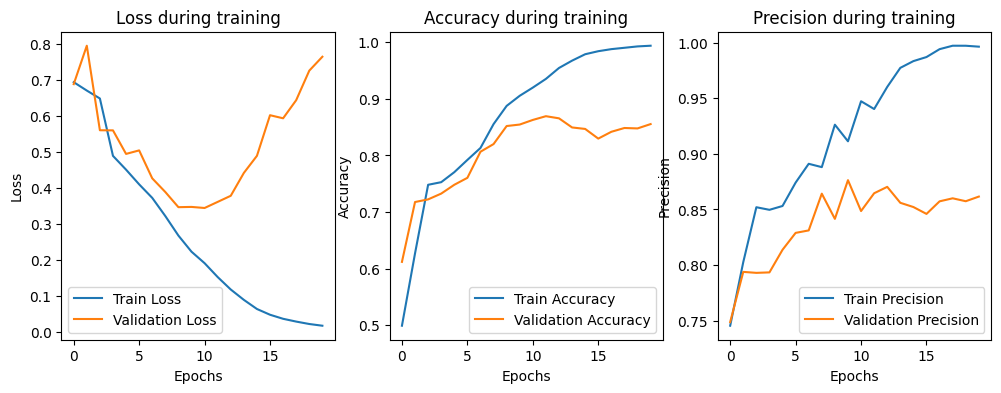

In [91]:
plot_hist(hst)

## U-net

2. **U-net** - Архитектура нейросети, созданная для сегментации изображений
Состоит из кодировщика и декодировщика
    1. *Кодировщик* - Состоит из свёрточных слоёв, позволяющих искать нужные признаки.
    2. *Декодировщик* - Состоит из транспонированных свёрточных слоёв, разворачивающих изображение и уменьшающих кол-во фильтров.

In [92]:
from tensorflow.keras.layers import *

In [96]:
def unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Энергия спуска
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Декодирование
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Используйте softmax, если у вас больше классов
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

In [97]:
inputs = Input(shape=(mass_img[0].shape))
# Кодировщик
c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)
# Декодировщик
u2 = UpSampling2D((2, 2))(p1)
u2 = Concatenate()([u2, c1])
c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
# Выходной слой
outputs = Conv2D(1, (1, 1), activation='sigmoid')(c2)

# Создаем модель
model_u = tf.keras.Model(inputs=[inputs], outputs=[outputs])

In [98]:
model_u1 = unet_model((300, 300, 3))

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 36, 36, 512), (None, 37, 37, 512)]

In [ ]:
# Компилируем модель
model_u.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision'])
model_u1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision'])

In [ ]:
type(y_t)

numpy.ndarray

In [ ]:
hst_u1 = model_u1.fit(x_t, y_t, validation_data=(x_v, y_v), epochs=10, batch_size=32)

In [ ]:
# Обучаем модель
hst_u = model_u.fit(x_t, y_t, validation_data=(x_v, y_v), epochs=10, batch_size=32)

Epoch 1/10


c:\PyInterpreters\BigData\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_39']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.9224 - loss: 0.2540 - precision: 0.9226 - val_accuracy: 0.8257 - val_loss: 0.8865 - val_precision: 0.8079
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.7882 - loss: 0.9409 - precision: 0.7635 - val_accuracy: 0.9557 - val_loss: 0.1809 - val_precision: 0.9649
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.9358 - loss: 0.2282 - precision: 0.9387 - val_accuracy: 0.8691 - val_loss: 0.4159 - val_precision: 0.9952
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.8985 - loss: 0.4161 - precision: 0.9885 - val_accuracy: 0.8322 - val_loss: 0.4764 - val_precision: 0.9970
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.8808 - loss: 0.4662 - precision: 0.9930 - val_accuracy: 0.8749 - val_loss: 0.3753 - val_precision: 0.9947
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.9020 - loss: 0.3768 - precision: 0.9874 - val_accuracy: 0.9231 - val_loss: 0.2741 - val_precision: 0.98

In [ ]:
plot_results(x_v, y_v, model_u1.predict(x_v), 2 * 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


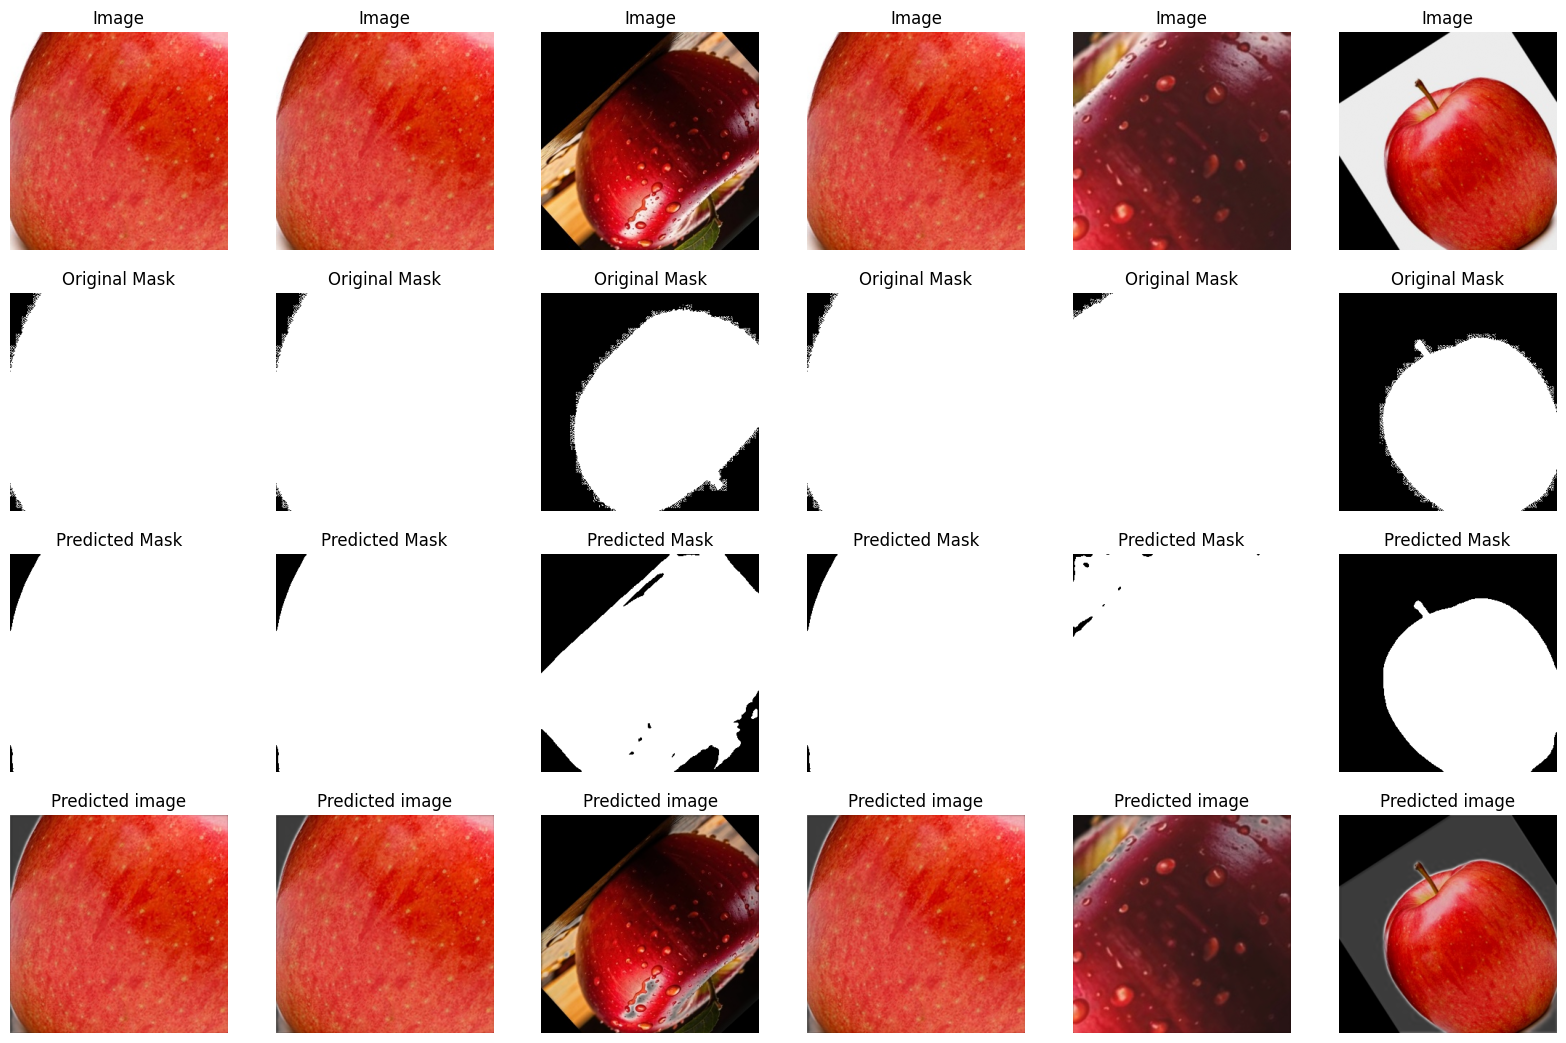

In [ ]:
plot_results(x_v, y_v, model_u.predict(x_v), 2 * 3)

In [ ]:
plot_hist(hst_u1)

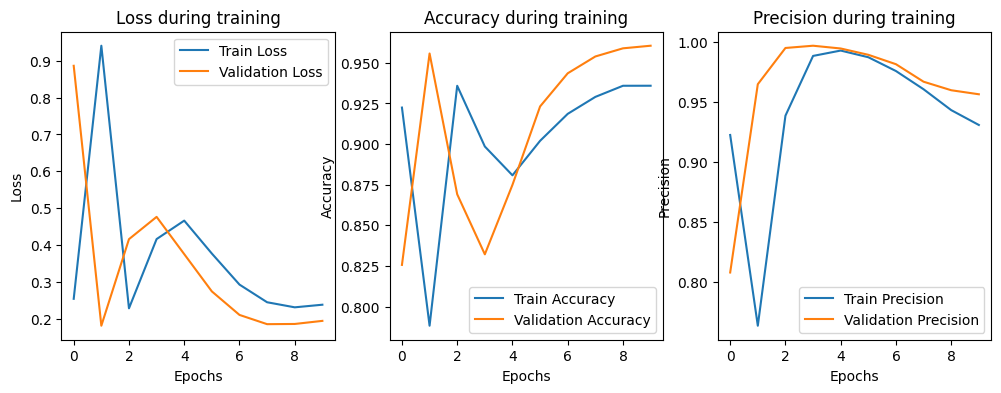

In [99]:
plot_hist(hst_u)